In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy

C:\Users\hp\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: Futu

In [3]:
# Check if GPU is available
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
# Check tensorflow version
tf.__version__

'2.8.0'

In [5]:
# check state of GPUs
!nvidia-smi

Thu Apr 28 15:18:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.33       Driver Version: 497.33       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |     88MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generic Initialization

In [6]:
def flattenmask(mask):
    """Returns the nodes of mask flattened
    Input:
    mask - the mask position, in dictionary form
    Output:
    maskflatten - the mask position, flattened out in 1D array
    """
    maskflatten = []
    for k, v in mask.items():
        curmask = v.flatten()
        maskflatten = np.hstack([maskflatten, curmask])
    return maskflatten

def getmask(layers, mask, maskflatten, mask_type = 'min', percentile = 0.2, printactivation = False, dropOne = False):
    """ Updates mask after each training cycle
    Inputs:
    layers - Predicted node value per layer
    mask - current mask
    mask_type - type of mask: min, max, random, min_layer, max_layer, random_layer
    maskflatten - Flattened masked indices per layer (1 for mask, 0 for no mask)
    percentile - percentage of nodes remaining to be masked
    printactivation - Boolean. Whether to print the activations per layer
    dropOne - Boolean. Whether to drop only one node/filter at a time
    
    Output:
    mask - final masks after masking percentile proportion of remaining nodes
    """
    nodevalues = []
    layermeans = {}
    
    # if only drop one, then percentile is 0
    if dropOne:
        percentile = 0
    
    # if only one layer
    if(len(mask)==1):
        layermeans[0] = np.mean(np.abs(layers), axis = 0).ravel()
        nodevalues = np.hstack([nodevalues, layermeans[0]])
        if printactivation:
            print('Layer activations:', layermeans[0])
        
    # if more than one layer
    else:
        for i in range(len(mask)):
            layermeans[i] = np.mean(np.abs(layers[i]), axis = 0).ravel()
            nodevalues = np.hstack([nodevalues, layermeans[i]])
            if printactivation:
                print('Layer activations:', layermeans[i])

    # remove only those in maskindex
    maskflatten = np.ravel(np.where(maskflatten == 1))
    
    # find out the threshold node/filter value to remove
    if len(maskflatten) > 0:
        # for max mask
        if mask_type == 'max':
            sortedvalues = -np.sort(-nodevalues[maskflatten])
            index = int((percentile)*len(sortedvalues))
            maxindex = sortedvalues[index]
            
        # for min or % mask
        else:
            sortedvalues = np.sort(nodevalues[maskflatten])
            index = int(percentile*len(sortedvalues))
            maxindex = sortedvalues[index]
                           
    # Calculate the number of nodes to remove
    nummask = 0
    
    for v in mask.values():
        nummask += np.sum(v)
    
    totalnodes = int((percentile)*nummask)
    
    if dropOne:
        totalnodes = 1

    # remove at least one node
    if (totalnodes == 0):
        totalnodes = 1
    
    # identify the indices to drop for random mask
    if mask_type == 'random':
        indices = np.random.permutation(maskflatten)
        # take only the first totalnodes number of nodes
        indices = indices[:totalnodes]
        
        dropmaskindex = {}
        startindex = 0
        # assign nodes/filters to drop for each layer in dropmaskindex
        for k, v in mask.items():
            nummask += np.sum(v)
            dropmaskindex[k] = indices[(indices>=startindex) & (indices < startindex + len(v))] - startindex
            startindex += len(v)
        
    for i, layermean in layermeans.items():

        #only if there is something to drop in current mask
        if(np.sum(mask[i])>0):
            # Have different indices for different masks
            if mask_type == 'max':
                indices = np.ravel(np.where(layermean>=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # global random mask or layer random mask
            elif mask_type == 'random_layer':
                indices = np.ravel(np.where(mask[i].ravel()))
                curindices = np.ravel(np.where(mask[i].ravel()))
            elif mask_type == 'random':
                indices = dropmaskindex[i]
                curindices = np.ravel(np.where(mask[i].ravel()))
            # layer-wise max mask
            elif mask_type == 'max_layer':
                sortedvalues = -np.sort(-layermean[mask[i]==1])
                index = int((percentile)*len(sortedvalues))
                maxindex = sortedvalues[index]
                indices = np.ravel(np.where(layermean>=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # layer-wise min mask
            elif mask_type == 'min_layer':
                sortedvalues = np.sort(layermean[mask[i]==1])
                index = int((percentile)*len(sortedvalues))
                maxindex = sortedvalues[index]
                indices = np.ravel(np.where(layermean<=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # if this is min mask or % based mask
            else:
                indices = np.ravel(np.where(layermean<=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
                
        else:
            #default
            indices = np.ravel(np.where(mask[i]==1))

        # shuffle the indices only if we are not dropping one node/filter
        if (dropOne == False):
            indices = np.random.permutation(indices)

        newmask = mask[i].ravel()

        # for layer masks, total nodes dropped is by percentile of the layer of each mask
        if(mask_type == 'random_layer') or mask_type == 'min_layer' or mask_type == 'max_layer':
            initialpercent = np.sum(mask[i])*1.0/len(mask[i].ravel())
            totalnodes = int(initialpercent*(percentile)*len(mask[i].ravel()))

            # remove at least 1 node
            if (totalnodes == 0):
                totalnodes = 1

        if(len(indices)>0):

            # remove at most totalnodes number of nodes
            if(len(indices)>totalnodes):
                indices = indices[:totalnodes]

            # remove nodes
            newmask[indices] = 0

            # updated totalnodes to be removed
            totalnodes = totalnodes - len(indices)

        # reshape to fit new mask
        mask[i] = newmask.reshape(mask[i].shape)

    return mask

def resetmask(mask):
    """Resets mask to initial start state of all ones"""
    for k, v in mask.items():
        mask[k] = np.ones_like(v)
    
    return mask

def comparemask(mask1, mask2):
    """ Compares how similar both masks (mask1, mask2) are and returns a percentage similarity """
    count = 0
    totalcount = 0
    for k, v in mask1.items():
        count += np.sum(mask1[k] == mask2[k])
        totalcount += len(mask1[k].ravel())
        
    return count/totalcount

def percentmask(mask):
    """Returns the percentage of mask that contains 1s"""
    nummask = 0
    totalmask = 0
    
    for v in mask.values():
        nummask += np.sum(v)
        totalmask += len(v.ravel())
        
    return nummask/totalmask

In [7]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def comparerandom(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
                                    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)], 
                 metrics = ['accuracy'], num_epochs = 100, percentile = 0.2, verbose = 0, numtrials = 15, printvalue = True, printmask = False, printactivation = False):
    """ Function to compare metrics with randominit 
    Inputs:
    opt - Keras optimizer
    loss - Keras loss
    callbacks - Keras callbacks
    metrics - Keras metrics
    num_epochs - Number of epochs for each training cycle
    percentile - Percentile to drop the nodes
    verbose - Keras verbose option
    numtrials - Number of different experiments to run, each with different random seed
    printvalue  - Boolean. Whether to print the accuracies and losses for each pruning percentage
    printmask - Boolean. Whether to print the mask values
    printactivation - Boolean. Whether to print the node/filter's activation values
    
    Output:
    caches - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    """

    # Initialize variables
    percentremoved ={}
    train_accuracies = {}
    valid_accuracies = {}
    test_accuracies = {}
    train_losses = {}
    valid_losses ={}
    test_losses = {}
    early_stopping = {}
    oraclecomparison = {}
    masktypes = ['min', 'randominit']
    
    for masktype in masktypes:
        percentremoved[masktype] = []
        train_accuracies[masktype] = []
        valid_accuracies[masktype] = []
        test_accuracies[masktype] = []
        train_losses[masktype] = []
        valid_losses[masktype] = []
        test_losses[masktype] = []
        early_stopping[masktype] = []
        
    # do for numtrials number of random seeds
    for random_seed in range(numtrials):
        print('>>>     Random seed number:', random_seed)

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)   
        
        # Initialize the model
        mask, model, activationmodel = initializemodel()
        # model.summary()
        model.compile(optimizer = opt, loss = loss, metrics = metrics)
        
        # save original weights
        weights_initial = model.get_weights()

        mask=resetmask(mask)
        percent = percentmask(mask)

        while percent > 0.1:
            print('\n>>> Currently doing min mask <<<')
            tf.keras.backend.clear_session()
            np.random.seed(random_seed)
            tf.random.set_seed(random_seed)  
            
            # Initialize the model with the new mask
            _, model, activationmodel = initializemodel(mask)

            #Initialize to original weights
            model.set_weights(weights_initial)
            model.compile(optimizer = opt, loss = loss, metrics = metrics)

            history = model.fit(x_train, y_train, epochs = num_epochs, validation_data = (x_val, y_val), shuffle = False, callbacks = callbacks, verbose = verbose)
            results = model.evaluate(x_test, y_test, verbose = 0)

            percent = percentmask(mask)
            train_accuracy = history.history['accuracy'][-1]
            valid_accuracy = history.history['val_accuracy'][-1]
            test_accuracy = results[1]
            train_loss = history.history['loss'][-1]
            valid_loss = history.history['val_loss'][-1]
            test_loss = results[0]
            early = len(history.history['accuracy'])

            # Append the values for accuracy and loss
            percentremoved['min'].append(percent)
            train_accuracies['min'].append(train_accuracy)
            valid_accuracies['min'].append(valid_accuracy)
            test_accuracies['min'].append(test_accuracy)
            train_losses['min'].append(train_loss)
            valid_losses['min'].append(valid_loss)
            test_losses['min'].append(test_loss)
            early_stopping['min'].append(early)

            if printvalue:
                print('Percentage remaining', percent, end = ' ')
                print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                if printmask:
                    print('Mask:', mask)
                print('Train Acc:', train_accuracy, end = ' ')
                print('Val Acc:', valid_accuracy, end = ' ')
                print('Test Acc:', test_accuracy)
                print('Train Loss:', train_loss, end = ' ')
                print('Val loss:', valid_loss, end = ' ')
                print('Test Loss:', test_loss)
                print('Early stopping iteration:', early)
                
            # Remove nodes for next iteration based on metric
            layers = activationmodel.predict(x_train)
            maskflatten = flattenmask(mask)

            # random init mask
            print('\n>>> Currently doing randominit mask <<<')
            # Initialize the model with the new mask with random seed
            tf.keras.backend.clear_session()
            np.random.seed(random_seed+20)
            tf.random.set_seed(random_seed+20)    
            _, model, activationmodel = initializemodel(mask)

            model.compile(optimizer = opt, loss = loss, metrics = metrics)

            history = model.fit(x_train, y_train, epochs = num_epochs, validation_data = (x_val, y_val), shuffle = False, callbacks = callbacks, verbose = verbose)
            results = model.evaluate(x_test, y_test, verbose = 0)

            percent = percentmask(mask)
            train_accuracy = history.history['accuracy'][-1]
            valid_accuracy = history.history['val_accuracy'][-1]
            test_accuracy = results[1]
            train_loss = history.history['loss'][-1]
            valid_loss = history.history['val_loss'][-1]
            test_loss = results[0]
            early = len(history.history['accuracy'])

            # Append the values for accuracy and loss
            percentremoved['randominit'].append(percent)
            train_accuracies['randominit'].append(train_accuracy)
            valid_accuracies['randominit'].append(valid_accuracy)
            test_accuracies['randominit'].append(test_accuracy)
            train_losses['randominit'].append(train_loss)
            valid_losses['randominit'].append(valid_loss)
            test_losses['randominit'].append(test_loss)
            early_stopping['randominit'].append(early)

            if printvalue:
                print('Percentage remaining', percent, end = ' ')
                print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                if printmask:
                    print('Mask:', mask)
                print('Train Acc:', train_accuracy, end = ' ')
                print('Val Acc:', valid_accuracy, end = ' ')
                print('Test Acc:', test_accuracy)
                print('Train Loss:', train_loss, end = ' ')
                print('Val loss:', valid_loss, end = ' ')
                print('Test Loss:', test_loss)
                print('Early stopping iteration:', early)
                
            # get new mask
            mask = getmask(layers, mask, maskflatten, mask_type = 'min', percentile = percentile)
            
        cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
        printgraph(cache, 'randominit'+str(random_seed), numtrials = random_seed+1)

    cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
    return cache

C:\Users\hp\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [8]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def generatemodel(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'],
                  callbacks = [EarlyStopping(monitor='val_loss', mode = 'min', verbose=0, patience=5)], 
                    num_epochs = 100, percentile = 0.2, verbose = 0, numtrials = 15, printvalue = True, printmask = False, printactivation = False):
    """ Function to evaluate the model against various metrics
    Inputs:
    opt - Keras optimizer
    loss - Keras loss
    metrics - Keras metrics
    callbacks - Keras callbacks
    num_epochs - Number of epochs for each training cycle
    percentile - Percentile to drop the nodes
    verbose - Keras verbose option
    numtrials - Number of different experiments to run, each with different random seed
    printvalue  - Boolean. Whether to print the accuracies and losses for each pruning percentage
    printmask - Boolean. Whether to print the mask values
    printactivation - Boolean. Whether to print the node/filter's activation values
    
    Output:
    caches - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    """

    # Initialize variables
    percentremoved ={}
    train_accuracies = {}
    valid_accuracies = {}
    test_accuracies = {}
    train_losses = {}
    valid_losses ={}
    test_losses = {}
    early_stopping = {}
    oraclecomparison = {}
    masktypes = ['min', 'max', 'random', 'min_layer', 'max_layer', 'random_layer']
    
    for masktype in masktypes:
        percentremoved[masktype] = []
        train_accuracies[masktype] = []
        valid_accuracies[masktype] = []
        test_accuracies[masktype] = []
        train_losses[masktype] = []
        valid_losses[masktype] = []
        test_losses[masktype] = []
        early_stopping[masktype] = []
        
    # do for numtrials number of random seeds
    for random_seed in range(numtrials):
        print('>>>     Random seed number:', random_seed)

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)    
        
        # Initialize the model
        mask, model, activationmodel = initializemodel()
        # model.summary()
        model.compile(optimizer = opt, loss = loss, metrics = metrics)
        # save original weights
        weights_initial = model.get_weights()
    
    # do for all mask types
        for masktype in masktypes:
            print('\n>>> Currently doing', masktype, 'mask <<<')
        
            mask=resetmask(mask)
            percent = percentmask(mask)
            
            while percent > 0.1:
                # Initialize the model with the new mask
                tf.keras.backend.clear_session()
                np.random.seed(random_seed)
                tf.random.set_seed(random_seed)  
                
                _, model, activationmodel = initializemodel(mask)

                #Initialize to original weights
                model.set_weights(weights_initial)
                model.compile(optimizer = opt, loss = loss, metrics = metrics)  

                history = model.fit(x_train, y_train, epochs = num_epochs, validation_data = (x_val, y_val), callbacks = callbacks, shuffle = False, verbose = verbose)
                results = model.evaluate(x_test, y_test, verbose = 0)

                percent = percentmask(mask)
                train_accuracy = history.history['accuracy'][-1]
                valid_accuracy = history.history['val_accuracy'][-1]
                test_accuracy = results[1]
                train_loss = history.history['loss'][-1]
                valid_loss = history.history['val_loss'][-1]
                test_loss = results[0]
                early = len(history.history['accuracy'])

                # Append the values for accuracy and loss
                percentremoved[masktype].append(percent)
                train_accuracies[masktype].append(train_accuracy)
                valid_accuracies[masktype].append(valid_accuracy)
                test_accuracies[masktype].append(test_accuracy)
                train_losses[masktype].append(train_loss)
                valid_losses[masktype].append(valid_loss)
                test_losses[masktype].append(test_loss)
                early_stopping[masktype].append(early)

                if printvalue:
                    print('Percentage remaining', percent, end = ' ')
                    print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                    if printmask:
                        print('Mask:', mask)
                    print('Train Acc:', train_accuracy, end = ' ')
                    print('Val Acc:', valid_accuracy, end = ' ')
                    print('Test Acc:', test_accuracy)
                    print('Train Loss:', train_loss, end = ' ')
                    print('Val loss:', valid_loss, end = ' ')
                    print('Test Loss:', test_loss)
                    print('Early stopping iteration:', early)

                # Remove nodes for next iteration based on metric
                layers = activationmodel.predict(x_train)
                maskflatten = flattenmask(mask)
                mask = getmask(layers, mask, maskflatten, mask_type = masktype, percentile = percentile, printactivation = printactivation)
                
        cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
        printgraph(cache, 'evaluate'+str(random_seed), numtrials = random_seed+1)

    cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
    return cache

In [9]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def oraclemodel(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'],
                  callbacks = [EarlyStopping(monitor='val_loss', mode = 'min', verbose=0, patience=5)], 
                    num_epochs = 100, percentile = 0.2, verbose = 0, numtrials = 15, printvalue = True, printmask = False, printactivation = False):
    """ Function to evaluate the model against the oracle
    Inputs:
    opt - Keras optimizer
    loss - Keras loss
    metrics - Keras metrics
    callbacks - Keras callbacks
    num_epochs - Number of epochs for each training cycle
    percentile - Percentile to drop the nodes
    verbose - Keras verbose option
    numtrials - Number of different experiments to run, each with different random seed
    printvalue  - Boolean. Whether to print the accuracies and losses for each pruning percentage
    printmask - Boolean. Whether to print the mask values
    printactivation - Boolean. Whether to print the node/filter's activation values
    
    Output:
    caches - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    """

    # Initialize variables
    percentremoved ={}
    train_accuracies = {}
    valid_accuracies = {}
    test_accuracies = {}
    train_losses = {}
    valid_losses ={}
    test_losses = {}
    early_stopping = {}
    oraclecomparison = {}
    oraclemasks = []
    masktypes = ['oracle', 'min', 'max', 'random_layer']
    
    for masktype in masktypes:
        percentremoved[masktype] = []
        train_accuracies[masktype] = []
        valid_accuracies[masktype] = []
        test_accuracies[masktype] = []
        train_losses[masktype] = []
        valid_losses[masktype] = []
        test_losses[masktype] = []
        early_stopping[masktype] = []
        oraclecomparison[masktype] = []
        
    # do for numtrials number of random seeds
    for random_seed in range(numtrials):
        print('>>>     Random seed number:', random_seed)

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)    
        
        # Initialize the model
        mask, model, activationmodel = initializemodel()
        # model.summary()
        model.compile(optimizer = opt, loss = loss, metrics = metrics)
        # save original weights
        weights_initial = model.get_weights()
        
        # reset oracle masks
        oraclemasks = []
                 
        # do for all mask types
        for masktype in masktypes:
            print('\n>>> Currently doing', masktype, 'mask <<<')
        
            mask=resetmask(mask)
            percent = percentmask(mask)
            iterationnum = 0
            
            while percent > 0.1:
                # Initialize the model with the new mask
                tf.keras.backend.clear_session()
                np.random.seed(random_seed)
                tf.random.set_seed(random_seed)  
                
                _, model, activationmodel = initializemodel(mask)
                
                #Initialize to original weights
                model.set_weights(weights_initial)
                model.compile(optimizer = opt, loss = loss, metrics = metrics)  

                history = model.fit(x_train, y_train, epochs = num_epochs, validation_data = (x_val, y_val), callbacks = callbacks, shuffle = False, verbose = verbose)
                results = model.evaluate(x_test, y_test, verbose = 0)
                
                weights_after_training = model.get_weights()

                percent = percentmask(mask)
                train_accuracy = history.history['accuracy'][-1]
                valid_accuracy = history.history['val_accuracy'][-1]
                test_accuracy = results[1]
                train_loss = history.history['loss'][-1]
                valid_loss = history.history['val_loss'][-1]
                test_loss = results[0]
                early = len(history.history['accuracy'])

                # Append the values for accuracy and loss
                percentremoved[masktype].append(percent)
                train_accuracies[masktype].append(train_accuracy)
                valid_accuracies[masktype].append(valid_accuracy)
                test_accuracies[masktype].append(test_accuracy)
                train_losses[masktype].append(train_loss)
                valid_losses[masktype].append(valid_loss)
                test_losses[masktype].append(test_loss)
                early_stopping[masktype].append(early)
                
                # Compare mask with oracle if this is iteration 1 and above (when there is a mask to compare)
                if iterationnum == 0:
                    compare = 1
                else:
                    compare = comparemask(mask, oraclemasks[iterationnum-1])
                oraclecomparison[masktype].append(compare)

                if printvalue:
                    print('Percentage remaining', percent, end = ' ')
                    print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                    if printmask:
                        print('Mask:', mask)
                    print('Train Acc:', train_accuracy, end = ' ')
                    print('Val Acc:', valid_accuracy, end = ' ')
                    print('Test Acc:', test_accuracy)
                    print('Train Loss:', train_loss, end = ' ')
                    print('Val loss:', valid_loss, end = ' ')
                    print('Test Loss:', test_loss)
                    print('Early stopping iteration:', early)
                    print('Similaritiy with oracle:', compare)

                # Remove nodes for next iteration for oracle by doing brute force comparison
                if masktype == 'oracle':
                    bestloss = 1000000
                    bestmask = {}
                    
                    # Remove one existing node and compare accuracy
                    for v in mask.values():
                        for index in range(len(v)):
                            # remove mask index only if it is non-zero
                            if v[index] != 0:
                                
                                # take out mask index
                                v[index] = 0
                                
                                # do the mask evaluation
                                # Initialize the model with the new mask
                                _, model, activationmodel = initializemodel(mask)

                                #Initialize the weights to after training weights
                                model.set_weights(weights_after_training)
                                model.compile(optimizer = opt, loss = loss, metrics = metrics)
                                # evaluate model using training data only
                                results = model.evaluate(x_train, y_train, verbose = 0)
                                
                                # update accuracy and mask for best mask
                                if(results[0] < bestloss):
                                    bestloss = results[0]
                                    bestmask = copy.deepcopy(mask)
                                        
                                # put back mask index
                                v[index] = 1
                        
                    # store bestmask
                    mask = copy.deepcopy(bestmask)
                    oraclemasks.append(mask)
                    
                    if printvalue:
                        print('Final mask selected:', mask)
                    oraclecomparison[masktype].append(comparemask(mask, oraclemasks[iterationnum]))

                else:
                    # Remove nodes for next iteration based on metric
                    layers = activationmodel.predict(x_train)
                    maskflatten = flattenmask(mask)
                    mask = getmask(layers, mask, maskflatten, mask_type = masktype, percentile = percentile, printactivation = printactivation, dropOne = True)
                    oraclecomparison[masktype].append(comparemask(mask, oraclemasks[iterationnum]))
                    
                # Increment iteration number
                iterationnum = iterationnum + 1
                
        cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
        printgraph(cache, 'oracle'+str(random_seed), numtrials = random_seed+1)

    cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
    return cache

In [10]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def comparepercentmask(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'],
                  callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)], 
                    num_epochs = 100, percentile = 0.2, verbose = 0, numtrials = 15, printvalue = True, printmask = False, printactivation = False):
    """ Function to compare the effect of pruning proportions
    Inputs:
    opt - Keras optimizer
    loss - Keras loss
    metrics - Keras metrics
    callbacks - Keras callbacks
    num_epochs - Number of epochs for each training cycle
    percentile - Percentile to drop the nodes
    verbose - Keras verbose option
    numtrials - Number of different experiments to run, each with different random seed
    printvalue  - Boolean. Whether to print the accuracies and losses for each pruning percentage
    printmask - Boolean. Whether to print the mask values
    printactivation - Boolean. Whether to print the node/filter's activation values
    
    Output:
    caches - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    """

    # Initialize variables
    percentremoved ={}
    train_accuracies = {}
    valid_accuracies = {}
    test_accuracies = {}
    train_losses = {}
    valid_losses ={}
    test_losses = {}
    early_stopping = {}
    masktypes = ['0.2', '0.3', '0.4', '0.5', '0.9']
    
    for masktype in masktypes:
        percentremoved[masktype] = []
        train_accuracies[masktype] = []
        valid_accuracies[masktype] = []
        test_accuracies[masktype] = []
        train_losses[masktype] = []
        valid_losses[masktype] = []
        test_losses[masktype] = []
        early_stopping[masktype] = []
        
    # do for numtrials number of random seeds
    for random_seed in range(numtrials):
        print('>>>     Random seed number:', random_seed)

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)    
        
        # Initialize the model
        mask, model, activationmodel = initializemodel()
        # model.summary()
        model.compile(optimizer = opt, loss = loss, metrics = metrics)
        # save original weights
        weights_initial = model.get_weights()
    
    # do for all mask types
        for masktype in masktypes:
            print('\n>>> Currently doing', masktype, 'mask <<<')
        
            mask=resetmask(mask)
            percent = percentmask(mask)
            
            while percent > 0.1:
                # Initialize the model with the new mask
                tf.keras.backend.clear_session()
                np.random.seed(random_seed)
                tf.random.set_seed(random_seed)  
                
                _, model, activationmodel = initializemodel(mask)

                #Initialize to original weights
                model.set_weights(weights_initial)
                model.compile(optimizer = opt, loss = loss, metrics = metrics)  

                history = model.fit(x_train, y_train, epochs = num_epochs, validation_data = (x_val, y_val), callbacks = callbacks, shuffle = False, verbose = verbose)
                results = model.evaluate(x_test, y_test, verbose = 0)

                percent = percentmask(mask)
                train_accuracy = history.history['accuracy'][-1]
                valid_accuracy = history.history['val_accuracy'][-1]
                test_accuracy = results[1]
                train_loss = history.history['loss'][-1]
                valid_loss = history.history['val_loss'][-1]
                test_loss = results[0]
                early = len(history.history['accuracy'])

                # Append the values for accuracy and loss
                percentremoved[masktype].append(percent)
                train_accuracies[masktype].append(train_accuracy)
                valid_accuracies[masktype].append(valid_accuracy)
                test_accuracies[masktype].append(test_accuracy)
                train_losses[masktype].append(train_loss)
                valid_losses[masktype].append(valid_loss)
                test_losses[masktype].append(test_loss)
                early_stopping[masktype].append(early)

                if printvalue:
                    print('Percentage remaining', percent, end = ' ')
                    print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                    if printmask:
                        print('Mask:', mask)
                    print('Train Acc:', train_accuracy, end = ' ')
                    print('Val Acc:', valid_accuracy, end = ' ')
                    print('Test Acc:', test_accuracy)
                    print('Train Loss:', train_loss, end = ' ')
                    print('Val loss:', valid_loss, end = ' ')
                    print('Test Loss:', test_loss)
                    print('Early stopping iteration:', early)
                    
                # get the percentile from masktype
                if masktype == '0.1': 
                    percentile = 0.1
                elif masktype == '0.2': 
                    percentile = 0.2
                elif masktype == '0.3': 
                    percentile = 0.3
                elif masktype == '0.4': 
                    percentile = 0.4
                elif masktype == '0.5': 
                    percentile = 0.5
                elif masktype == '0.9': 
                    percentile = 0.9

                # Remove nodes for next iteration based on metric
                layers = activationmodel.predict(x_train)
                maskflatten = flattenmask(mask)
                mask = getmask(layers, mask, maskflatten, mask_type = 'min', percentile = percentile, printactivation = printactivation)

        cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
        printgraph(cache, 'comparepercentmask'+str(random_seed), numtrials = random_seed+1)
                
    cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
    return cache

In [11]:
def printgraph(cache, name, numtrials = 15, oracle = False):
    """Function to print graph
    Input: 
    cache - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    name - name of model which is run
    numtrials - number of experiments conducted
    oracle - Boolean. Whether the oraclecomparison graph is required
    
    Outputs:
    Graphs for training, validation, test accuracy, early stopping iteration, oracle comparison (optional)"""
    
    # unpack caches
    percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison = cache
    # sort masktypes by alphabetical order
    masktypes = sorted(percentremoved.keys())

    # Set colors
    colors = {}
    colors['min'] = 'b'
    colors['max'] = 'r'
    colors['random'] ='g'
    colors['random_layer'] = 'y'
    colors['min_layer'] = 'c'
    colors['max_layer'] = 'm'
    colors['randominit'] = 'y'
    colors['oracle'] = 'm'
    
    # colors for percentage mask
    colors['0.1'] = 'b'
    colors['0.2'] = 'r'
    colors['0.3'] = 'g'
    colors['0.4'] = 'y'
    colors['0.5'] = 'c'
    colors['0.9'] = 'm'
    
    # format for various masks
    fmt = {}
    fmt['min'] = '-'
    fmt['max'] = '-'
    fmt['random'] ='--'
    fmt['random_layer'] = '--'
    fmt['min_layer'] = '-'
    fmt['max_layer'] = '-'
    fmt['randominit'] = '--'
    fmt['minfast'] = '-'
    fmt['oracle'] = '-'
    
    fmt['0.1'] = '-'
    fmt['0.2'] = '-'
    fmt['0.3'] = '-'
    fmt['0.4'] = '-'
    fmt['0.5'] = '-'
    fmt['0.9'] = '-'
    
    import matplotlib.font_manager
    from matplotlib import rc, rcParams
    rc('font', family = 'STIXGeneral')
    rc('xtick', labelsize=10) 
    rcParams.update({'figure.autolayout': True})
    rcParams.update({'font.size': 14})
    
    # Plot figures for training accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:     
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(train_accuracies[masktype][i::length]))
            std.append(1.96*np.std(train_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)        
    plt.ylabel('Training accuracy')
    plt.xlabel('Proportion of nodes/filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/training_accuracy_{}.png'.format(name))

    # Plot figures for validation accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(valid_accuracies[masktype][i::length]))
            std.append(1.96*np.std(valid_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
    plt.ylabel('Validation accuracy')
    plt.xlabel('Proportion of nodes/filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/validation_accuracy_{}.png'.format(name))

    # Plot figures for test accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(test_accuracies[masktype][i::length]))
            std.append(1.96*np.std(test_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
    plt.ylabel('Test accuracy')
    plt.xlabel('Proportion of nodes/filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/test_accuracy_{}.png'.format(name))

    if oracle:
        # Plot figures for oracle comparison
        plt.figure()
        plt.gca().invert_xaxis()
        plt.xscale('log')
        plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
        for masktype in masktypes:
            length = len(percentremoved[masktype])//numtrials
            mean = []
            std = []
            for i in range(length):
                mean.append(np.mean(oraclecomparison[masktype][i::length]))
                std.append(1.96*np.std(oraclecomparison[masktype][i::length])/np.sqrt(numtrials))
            plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
        plt.ylabel('Test accuracy')
        plt.xlabel('Proportion of nodes/filters remaining')
        plt.legend(loc = 'lower left')
        plt.savefig('Images/oracle_comparison_{}.png'.format(name))

    # Plot figures for early stopping iteration
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(early_stopping[masktype][i::length]))
            std.append(1.96*np.std(early_stopping[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
        plt.ylabel('Early stopping iteration')
        plt.xlabel('Proportion of nodes/filters remaining')
        plt.legend(loc = 'lower left')
        plt.savefig('Images/early_stopping_{}.png'.format(name))

In [12]:
def AddMask(mask, model, activationarray, layer, initialize = True):
    """Function to add mask to current layer of nodes
    Inputs:
    mask - mask which contains either 0 (node/filter dropped) or 1 (node/filter remaining)
    model - Keras model, defined using Functional API
    activationarray - list of Keras layers of which we care about their activation values
    layer - the current layer number
    initialize - Boolean. True if we want to reset all the masks to 1
    
    Output:
    model - Updated Keras model with the mask layer
    activationarray - Updated list of layers which the activation values are important
    layer - the updated layer number count
    """
    # only initialize if this is the first time
    if initialize is True:
        mask[layer] = np.ones(model.shape[1:])
    model = Multiply()([model, tf.ones_like(model)*mask[layer].reshape(model.shape[1:])])
    activationarray.append(model)
    
    # increase layer count for next iteration
    layer = layer+1

    return model, activationarray, layer

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Lambda

def AddFilterMask(mask, model, activationarray, layer, initialize = True):
    """Function to add mask to filters in Conv2D
    Inputs:
    mask - mask which contains either 0 (node/filter dropped) or 1 (node/filter remaining)
    model - Keras model, defined using Functional API
    activationarray - list of Keras layers of which we care about their activation values
    layer - the current layer number
    initialize - Boolean. True if we want to reset all the masks to 1
    
    Output:
    model - Updated Keras model with the mask layer
    activationarray - Updated list of layers which the activation values are important
    layer - the updated layer number count
    """

    model2 = GlobalAveragePooling2D()(model)
    
    # only initialize if this is the first time
    if initialize is True:
        mask[layer] = np.ones(model2.shape[1:])
    # Multiply the activation with the filters
    model2 = Multiply()([model2, tf.ones_like(model2)*mask[layer].reshape(model2.shape[1:])])
    activationarray.append(model2)
    
    # do the multiply for the original filters using broadcasting
    model = Multiply()([model, tf.ones_like(model)*mask[layer].reshape(1, 1, model.shape[3])])
    
    # increase layer count for next iteration
    layer = layer+1

    return model, activationarray, layer

In [14]:
import pickle
def savefile(cache, name):
    """ Function which saves the cache """
    with open('Caches/'+name+'.p','wb') as outfile:
        pickle.dump(cache, outfile)
        
def loadfile(name):
    """ Function which loads the cache """
    with open('Caches/'+name+'.p','rb') as infile:
        cache = pickle.load(infile)
    return cache

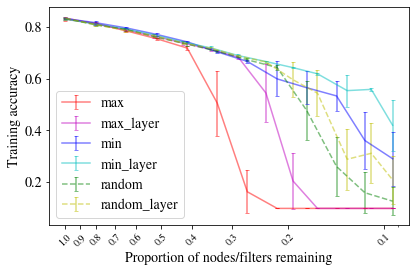

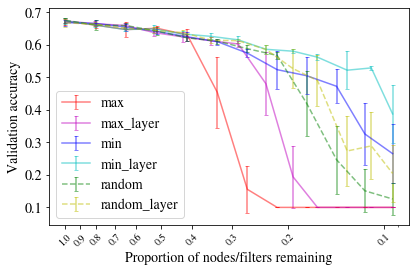

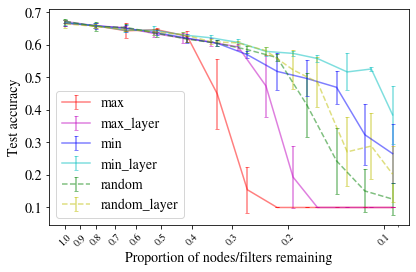

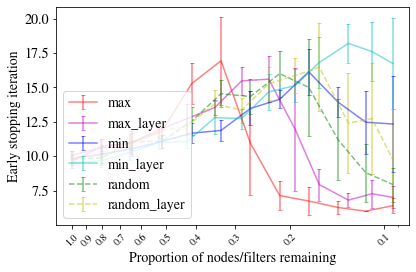

In [15]:
# This loads only one .p file to print the graphs
# Enter desired filename below
filename = 'cifar10_conv64x2_conv128x2_evaluate'

# Load cache
cache = loadfile(filename)

# print out graphs. Set oracle = True to see oraclecomparison (only valid for oraclemodel)
printgraph(cache, filename, numtrials = 15, oracle = False)

'zip' is not recognized as an internal or external command,
operable program or batch file.


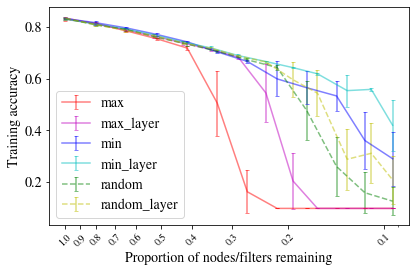

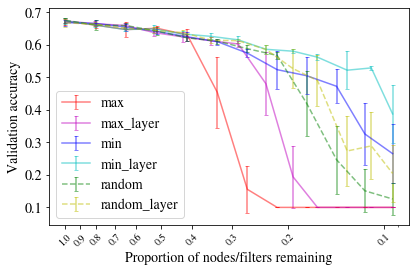

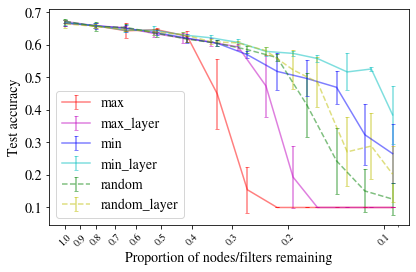

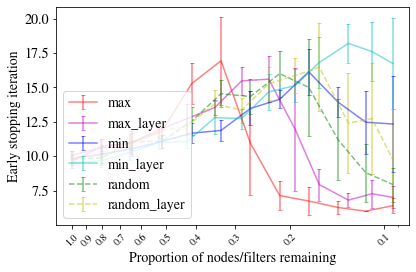

In [16]:
# This imports the entire Cache folder and prints out all the graphs
import os
for filename in os.listdir('Caches/'):
    if(filename[-1]=='p'):
        with open('Caches/'+filename,'rb') as infile:
                cache = pickle.load(infile)
        modelname = filename[:-2];
        printgraph(cache, modelname, numtrials = 15)

# this creates the zip file of images imag.zip
!zip imag.zip -r Images

## MNIST

In [16]:
from sklearn.model_selection import train_test_split

mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255.0

# split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify = y_train, test_size=0.1, random_state=42)

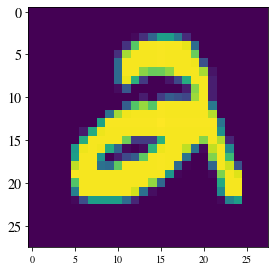

Classified as: 2


In [17]:
index = 394
plt.imshow(x_train[index].reshape(28, 28))
plt.show()
print('Classified as: ' + str(y_train[index]))

## Customize Model

In [18]:
from tensorflow.keras.layers import Dense, Input, Lambda, Multiply, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

def initializemodel(mask = None):
    """Initialize model with a certain mask"""
    activationarray = []
    layername = {}
    # if no mask specified, start with no mask
    layer = 0
    if mask is None:
        mask = {}
        initialize = True
    else:
        initialize = False
    
    inputs = Input(shape = [28, 28, 1])
    
    ## Define your model architecture below
    ## For every FC layer (dense layer), follow up with an AddMask line to add the node mask
    ## For every Conv Layer, follow up with an AddFilterMask line to add the filter mask
    
    # Model A (FC layers)
    model = Flatten()(inputs)
    
    model = Dense(40, activation = 'relu')(model)
    model, activationarray, layer = AddMask(mask, model, activationarray, layer, initialize = initialize)  
    model = Dense(40, activation = 'relu')(model)
    model, activationarray, layer = AddMask(mask, model, activationarray, layer, initialize = initialize) 
    
    out = Dense(10, activation = 'softmax')(model)
    
    model = Model(inputs = [inputs], outputs = [out])
    activationmodel = Model(inputs = [inputs], outputs = activationarray)
    
##     Model B (Conv layers)
    
#     model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(inputs)
#     model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize) 
#     model = MaxPooling2D((2, 2))(model)
#     model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(model)
#     model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
#     model = MaxPooling2D((2, 2))(model)    
    
#     model = Flatten()(model)
    
#     out = Dense(10, activation = 'softmax')(model)
    
#     model = Model(inputs = [inputs], outputs = [out])
#     activationmodel = Model(inputs = [inputs], outputs = activationarray)
    
    return mask, model, activationmodel

## Model Evaluation

In [19]:
## Model evaluation to compare all metrics
cache = generatemodel(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'], num_epochs = 100, numtrials = 15, percentile = 0.2, verbose = 0, printvalue = True, printmask = False, printactivation = False)

## Change your model name accordingly
modelname = 'mnist_dense40_dense40_evaluate'

## If want to print oraclecomparison graph, set to oracle = True (only for oraclemodel)
printgraph(cache, modelname, numtrials = 15, oracle = False)
savefile(cache, modelname)

>>>     Random seed number: 0


C:\Users\hp\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



>>> Currently doing min mask <<<
Percentage remaining 1.0 Layer nodes: [40.0, 40.0] Train Acc: 0.987333357334137 Val Acc: 0.9673333168029785 Test Acc: 0.965499997138977
Train Loss: 0.04126695543527603 Val loss: 0.13748516142368317 Test Loss: 0.13906922936439514
Early stopping iteration: 11
Percentage remaining 0.8 Layer nodes: [30.0, 34.0] Train Acc: 0.9828147888183594 Val Acc: 0.9635000228881836 Test Acc: 0.9631999731063843
Train Loss: 0.05775753781199455 Val loss: 0.1519286036491394 Test Loss: 0.13901785016059875
Early stopping iteration: 11
Percentage remaining 0.65 Layer nodes: [22.0, 30.0] Train Acc: 0.9786481261253357 Val Acc: 0.9616666436195374 Test Acc: 0.9611999988555908
Train Loss: 0.07130851596593857 Val loss: 0.14849062263965607 Test Loss: 0.144567608833313
Early stopping iteration: 13
Percentage remaining 0.525 Layer nodes: [17.0, 25.0] Train Acc: 0.9684814810752869 Val Acc: 0.9506666660308838 Test Acc: 0.9564999938011169
Train Loss: 0.10175183415412903 Val loss: 0.178877

C:\Users\hp\AppData\Local\Temp/ipykernel_16980/3063404079.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


>>>     Random seed number: 6

>>> Currently doing min mask <<<
Percentage remaining 1.0 Layer nodes: [40.0, 40.0] Train Acc: 0.9856296181678772 Val Acc: 0.9673333168029785 Test Acc: 0.97079998254776
Train Loss: 0.04680170863866806 Val loss: 0.12980712950229645 Test Loss: 0.1130700334906578
Early stopping iteration: 10
Percentage remaining 0.8 Layer nodes: [32.0, 32.0] Train Acc: 0.9852036833763123 Val Acc: 0.9626666903495789 Test Acc: 0.9646000266075134
Train Loss: 0.04844310134649277 Val loss: 0.14826324582099915 Test Loss: 0.13567298650741577
Early stopping iteration: 12
Percentage remaining 0.65 Layer nodes: [20.0, 32.0] Train Acc: 0.973537027835846 Val Acc: 0.9606666564941406 Test Acc: 0.9592999815940857
Train Loss: 0.08615929633378983 Val loss: 0.15344585478305817 Test Loss: 0.15339064598083496
Early stopping iteration: 11
Percentage remaining 0.525 Layer nodes: [16.0, 26.0] Train Acc: 0.9654444456100464 Val Acc: 0.9493333101272583 Test Acc: 0.9546999931335449
Train Loss: 0.11255